# LSTM Travel Time + Speed Prediction - N101.5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N101.5')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6398,74,45,2021042800
6412,74,45,2021042800
6426,74,45,2021042800
6440,74,45,2021042800
6454,74,45,2021042800
...,...,...,...
294409,75,44,2021051509
294423,75,44,2021051509
294437,75,44,2021051509
294451,75,44,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,74.000000,45.000000
2021042801,74.000000,45.000000
2021042802,74.000000,45.000000
2021042803,74.000000,45.000000
2021042804,74.000000,45.000000
...,...,...
2021051505,74.000000,45.000000
2021051506,74.000000,45.000000
2021051507,74.000000,45.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,0.923193
2021042801,0.923193
2021042802,0.923193
2021042803,0.923193
2021042804,0.923193
...,...
2021051505,0.923193
2021051506,0.923193
2021051507,0.923193


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

# LSTM - Time

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 9s 1s/step - loss: 0.6183 - mae: 0.6132 - rmse: 0.5606 - val_loss: 0.0389 - val_mae: 0.0389 - val_rmse: 0.0389
Epoch 2/300
3/3 [==============================] - 0s 90ms/step - loss: 0.0361 - mae: 0.0203 - rmse: 0.0422 - val_loss: 0.0387 - val_mae: 0.0387 - val_rmse: 0.0387
Epoch 3/300
3/3 [==============================] - 0s 96ms/step - loss: 0.0360 - mae: 0.0202 - rmse: 0.0421 - val_loss: 0.0384 - val_mae: 0.0384 - val_rmse: 0.0384
Epoch 4/300
3/3 [==============================] - 0s 109ms/step - loss: 0.0359 - mae: 0.0207 - rmse: 0.0420 - val_loss: 0.0380 - val_mae: 0.0380 - val_rmse: 0.0380
Epoch 5/300
3/3 [==============================] - 0s 137ms/step - loss: 0.0353 - mae: 0.0207 - rmse: 0.0413 - val_loss: 0.0355 - val_mae: 0.0355 - val_rmse: 0.0355
Epoch 6/300
3/3 [==============================] - 0s 108ms/step - loss: 0.0348 - mae: 0.0227 - rmse: 0.0408 - val_loss: 0.0292 - val_mae: 0.0292 - val_rmse: 0.0292
Epoch 7/300
3/3

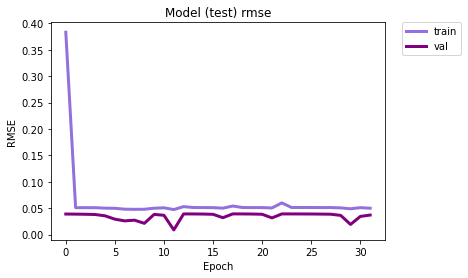

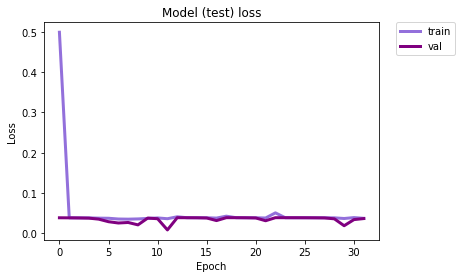

Epoch 1/300
5/5 [==============================] - 0s 97ms/step - loss: 0.0332 - mae: 0.0259 - rmse: 0.0316 - val_loss: 0.0300 - val_mae: 0.0211 - val_rmse: 0.0300
Epoch 2/300
5/5 [==============================] - 0s 85ms/step - loss: 0.0327 - mae: 0.0242 - rmse: 0.0309 - val_loss: 0.0299 - val_mae: 0.0211 - val_rmse: 0.0299
Epoch 3/300
5/5 [==============================] - 0s 102ms/step - loss: 0.0305 - mae: 0.0230 - rmse: 0.0281 - val_loss: 0.0301 - val_mae: 0.0210 - val_rmse: 0.0301
Epoch 4/300
5/5 [==============================] - 0s 86ms/step - loss: 0.0319 - mae: 0.0248 - rmse: 0.0315 - val_loss: 0.0305 - val_mae: 0.0209 - val_rmse: 0.0305
Epoch 5/300
5/5 [==============================] - 0s 98ms/step - loss: 0.0306 - mae: 0.0224 - rmse: 0.0292 - val_loss: 0.0304 - val_mae: 0.0209 - val_rmse: 0.0304
Epoch 6/300
5/5 [==============================] - 0s 89ms/step - loss: 0.0325 - mae: 0.0237 - rmse: 0.0305 - val_loss: 0.0301 - val_mae: 0.0210 - val_rmse: 0.0301
Epoch 7/300
5/5

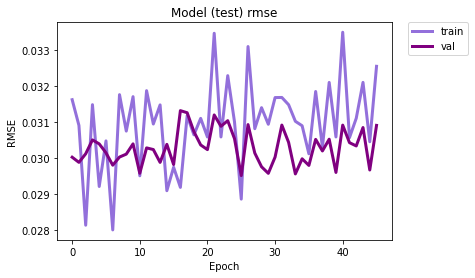

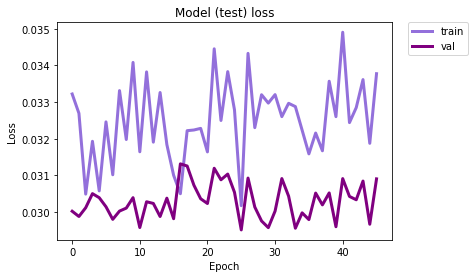

Epoch 1/300
7/7 [==============================] - 1s 107ms/step - loss: 0.0779 - mae: 0.0491 - rmse: 0.1690 - val_loss: 0.0910 - val_mae: 0.0412 - val_rmse: 0.0624
Epoch 2/300
7/7 [==============================] - 1s 84ms/step - loss: 0.0763 - mae: 0.0466 - rmse: 0.1673 - val_loss: 0.0906 - val_mae: 0.0422 - val_rmse: 0.0612
Epoch 3/300
7/7 [==============================] - 1s 95ms/step - loss: 0.0760 - mae: 0.0475 - rmse: 0.1672 - val_loss: 0.0902 - val_mae: 0.0429 - val_rmse: 0.0602
Epoch 4/300
7/7 [==============================] - 1s 86ms/step - loss: 0.0770 - mae: 0.0470 - rmse: 0.1681 - val_loss: 0.0906 - val_mae: 0.0421 - val_rmse: 0.0612
Epoch 5/300
7/7 [==============================] - 1s 81ms/step - loss: 0.0789 - mae: 0.0475 - rmse: 0.1698 - val_loss: 0.0907 - val_mae: 0.0419 - val_rmse: 0.0616
Epoch 6/300
7/7 [==============================] - 1s 85ms/step - loss: 0.0778 - mae: 0.0487 - rmse: 0.1689 - val_loss: 0.0912 - val_mae: 0.0410 - val_rmse: 0.0627
Epoch 7/300
7/7

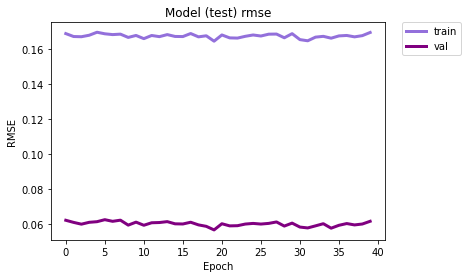

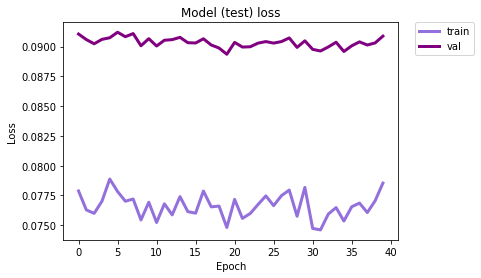

Epoch 1/300
9/9 [==============================] - 1s 83ms/step - loss: 0.0999 - mae: 0.0441 - rmse: 0.0941 - val_loss: 0.0270 - val_mae: 0.0194 - val_rmse: 0.0347
Epoch 2/300
9/9 [==============================] - 1s 81ms/step - loss: 0.0994 - mae: 0.0437 - rmse: 0.0932 - val_loss: 0.0271 - val_mae: 0.0188 - val_rmse: 0.0350
Epoch 3/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1000 - mae: 0.0430 - rmse: 0.0938 - val_loss: 0.0274 - val_mae: 0.0181 - val_rmse: 0.0354
Epoch 4/300
9/9 [==============================] - 1s 87ms/step - loss: 0.0981 - mae: 0.0425 - rmse: 0.0922 - val_loss: 0.0270 - val_mae: 0.0191 - val_rmse: 0.0348
Epoch 5/300
9/9 [==============================] - 1s 83ms/step - loss: 0.0979 - mae: 0.0428 - rmse: 0.0918 - val_loss: 0.0270 - val_mae: 0.0194 - val_rmse: 0.0347
Epoch 6/300
9/9 [==============================] - 1s 76ms/step - loss: 0.0989 - mae: 0.0427 - rmse: 0.0931 - val_loss: 0.0270 - val_mae: 0.0192 - val_rmse: 0.0348
Epoch 7/300
9/9 

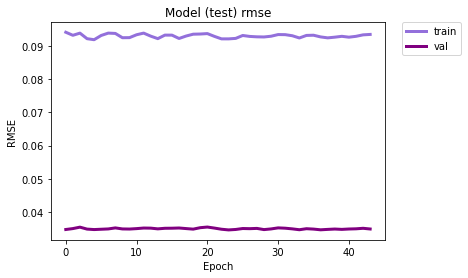

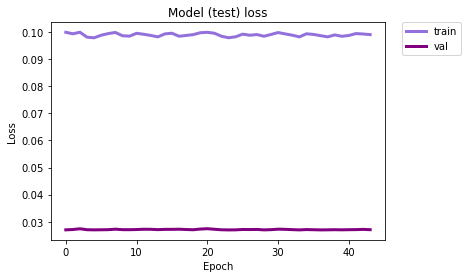

Epoch 1/300
11/11 [==============================] - 1s 72ms/step - loss: 0.0853 - mae: 0.0401 - rmse: 0.0816 - val_loss: 0.0543 - val_mae: 0.0321 - val_rmse: 0.0555
Epoch 2/300
11/11 [==============================] - 1s 64ms/step - loss: 0.0850 - mae: 0.0386 - rmse: 0.0814 - val_loss: 0.0542 - val_mae: 0.0321 - val_rmse: 0.0555
Epoch 3/300
11/11 [==============================] - 1s 64ms/step - loss: 0.0854 - mae: 0.0387 - rmse: 0.0814 - val_loss: 0.0536 - val_mae: 0.0321 - val_rmse: 0.0549
Epoch 4/300
11/11 [==============================] - 1s 60ms/step - loss: 0.0858 - mae: 0.0396 - rmse: 0.0821 - val_loss: 0.0544 - val_mae: 0.0320 - val_rmse: 0.0557
Epoch 5/300
11/11 [==============================] - 1s 55ms/step - loss: 0.0858 - mae: 0.0392 - rmse: 0.0818 - val_loss: 0.0541 - val_mae: 0.0321 - val_rmse: 0.0554
Epoch 6/300
11/11 [==============================] - 1s 59ms/step - loss: 0.0860 - mae: 0.0391 - rmse: 0.0822 - val_loss: 0.0546 - val_mae: 0.0320 - val_rmse: 0.0558
Epoc

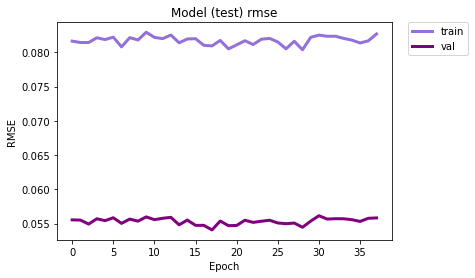

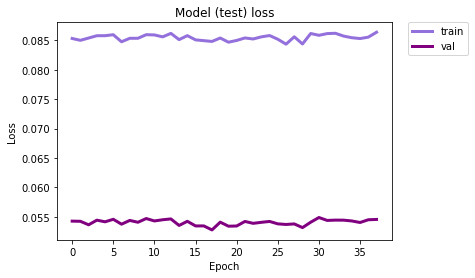

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.98847264
Transformed yhat 49.110867
yhat -0.9885571
Transformed yhat 49.109768
yhat -0.9886426
Transformed yhat 49.108654
yhat -0.98873013
Transformed yhat 49.107513
yhat -0.9888851
Transformed yhat 49.105495
yhat -0.9889529
Transformed yhat 49.104614
yhat -0.989011
Transformed yhat 49.103855
yhat -0.98907423
Transformed yhat 49.103035
yhat -0.9891462
Transformed yhat 49.102097
yhat -0.9891957
Transformed yhat 49.10145
yhat -0.98923284
Transformed yhat 49.100967
yhat -0.989275
Transformed yhat 49.100418
Real data: [49.73765704 49.47214357 49.47214357 53.00248924 49.30169049 48.96078431
 49.41314058 50.15395592 49.36397142 48.96078431 49.43203697 49.47214357
 49.47214357 49.47214357 49.47214357 49.47214357 49.47214357 49.47214357
 49.47214357 49.47214357 49.47214357 49.47214357 49.57048189 48.96078431]
Forecasting values: [49.1, 49.1, 49.1, 49.1, 49.1, 49.1, 49.1, 49.1, 49.1, 49.1, 49.1, 49.1]


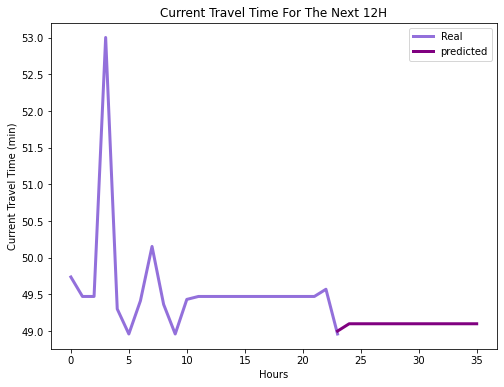

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.5',forecasts[i],hour[i]
        writer.writerow(d)
        

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 9s 914ms/step - loss: 0.6452 - mae: 0.6387 - rmse: 0.5885 - val_loss: 0.0765 - val_mae: 0.0765 - val_rmse: 0.0765
Epoch 2/300
3/3 [==============================] - 0s 94ms/step - loss: 0.0790 - mae: 0.0428 - rmse: 0.0840 - val_loss: 0.0764 - val_mae: 0.0764 - val_rmse: 0.0764
Epoch 3/300
3/3 [==============================] - 0s 100ms/step - loss: 0.0790 - mae: 0.0431 - rmse: 0.0838 - val_loss: 0.0759 - val_mae: 0.0759 - val_rmse: 0.0759
Epoch 4/300
3/3 [==============================] - 0s 123ms/step - loss: 0.0784 - mae: 0.0429 - rmse: 0.0831 - val_loss: 0.0740 - val_mae: 0.0740 - val_rmse: 0.0740
Epoch 5/300
3/3 [==============================] - 0s 85ms/step - loss: 0.0756 - mae: 0.0452 - rmse: 0.0802 - val_loss: 0.0470 - val_mae: 0.0469 - val_rmse: 0.0470
Epoch 6/300
3/3 [==============================] - 0s 110ms/step - loss: 0.0697 - mae: 0.0533 - rmse: 0.0749 - val_loss: 0.0339 - val_mae: 0.0339 - val_rmse: 0.0339
Epoch 7/300


3/3 [==============================] - 0s 105ms/step - loss: 0.0773 - mae: 0.0510 - rmse: 0.0812 - val_loss: 0.0521 - val_mae: 0.0521 - val_rmse: 0.0521
Epoch 51/300
3/3 [==============================] - 0s 113ms/step - loss: 0.0710 - mae: 0.0539 - rmse: 0.0752 - val_loss: 0.0366 - val_mae: 0.0366 - val_rmse: 0.0366
Epoch 52/300
3/3 [==============================] - 0s 97ms/step - loss: 0.0663 - mae: 0.0526 - rmse: 0.0710 - val_loss: 0.0251 - val_mae: 0.0251 - val_rmse: 0.0251
Epoch 53/300
3/3 [==============================] - 0s 88ms/step - loss: 0.0639 - mae: 0.0462 - rmse: 0.0686 - val_loss: 0.0138 - val_mae: 0.0138 - val_rmse: 0.0138
Epoch 54/300
3/3 [==============================] - 0s 129ms/step - loss: 0.0872 - mae: 0.0593 - rmse: 0.0902 - val_loss: 0.0583 - val_mae: 0.0583 - val_rmse: 0.0583
Epoch 55/300
3/3 [==============================] - 0s 114ms/step - loss: 0.0697 - mae: 0.0492 - rmse: 0.0735 - val_loss: 0.0021 - val_mae: 0.0020 - val_rmse: 0.0021
Epoch 56/300
3/3 [=

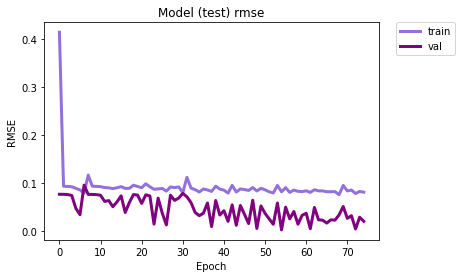

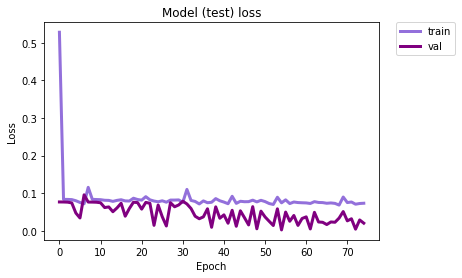

Epoch 1/300
5/5 [==============================] - 0s 98ms/step - loss: 0.0694 - mae: 0.0572 - rmse: 0.0702 - val_loss: 0.0653 - val_mae: 0.0511 - val_rmse: 0.0653
Epoch 2/300
5/5 [==============================] - 0s 82ms/step - loss: 0.0659 - mae: 0.0513 - rmse: 0.0646 - val_loss: 0.0656 - val_mae: 0.0485 - val_rmse: 0.0656
Epoch 3/300
5/5 [==============================] - 0s 84ms/step - loss: 0.0639 - mae: 0.0505 - rmse: 0.0612 - val_loss: 0.0657 - val_mae: 0.0481 - val_rmse: 0.0657
Epoch 4/300
5/5 [==============================] - 0s 87ms/step - loss: 0.0609 - mae: 0.0476 - rmse: 0.0594 - val_loss: 0.0656 - val_mae: 0.0484 - val_rmse: 0.0656
Epoch 5/300
5/5 [==============================] - 0s 94ms/step - loss: 0.0654 - mae: 0.0516 - rmse: 0.0633 - val_loss: 0.0663 - val_mae: 0.0471 - val_rmse: 0.0663
Epoch 6/300
5/5 [==============================] - 0s 83ms/step - loss: 0.0649 - mae: 0.0506 - rmse: 0.0631 - val_loss: 0.0665 - val_mae: 0.0468 - val_rmse: 0.0665
Epoch 7/300
5/5 

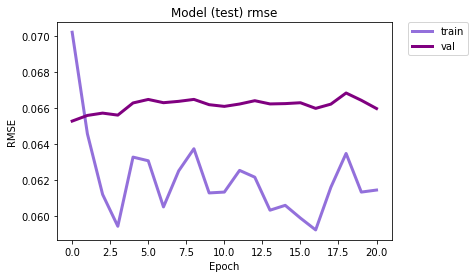

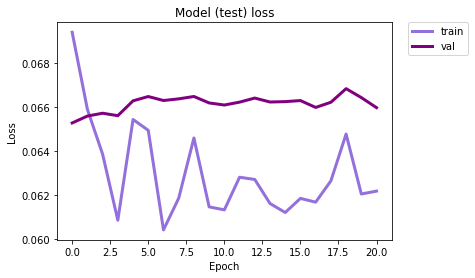

Epoch 1/300
7/7 [==============================] - 1s 145ms/step - loss: 0.1084 - mae: 0.0774 - rmse: 0.1948 - val_loss: 0.1609 - val_mae: 0.0806 - val_rmse: 0.0971
Epoch 2/300
7/7 [==============================] - 1s 122ms/step - loss: 0.1047 - mae: 0.0728 - rmse: 0.1925 - val_loss: 0.1607 - val_mae: 0.0808 - val_rmse: 0.0964
Epoch 3/300
7/7 [==============================] - 1s 96ms/step - loss: 0.1067 - mae: 0.0746 - rmse: 0.1931 - val_loss: 0.1602 - val_mae: 0.0812 - val_rmse: 0.0950
Epoch 4/300
7/7 [==============================] - 1s 130ms/step - loss: 0.1080 - mae: 0.0759 - rmse: 0.1961 - val_loss: 0.1611 - val_mae: 0.0803 - val_rmse: 0.0977
Epoch 5/300
7/7 [==============================] - 1s 148ms/step - loss: 0.1076 - mae: 0.0754 - rmse: 0.1951 - val_loss: 0.1609 - val_mae: 0.0804 - val_rmse: 0.0972
Epoch 6/300
7/7 [==============================] - 1s 100ms/step - loss: 0.1071 - mae: 0.0743 - rmse: 0.1927 - val_loss: 0.1604 - val_mae: 0.0808 - val_rmse: 0.0957
Epoch 7/300

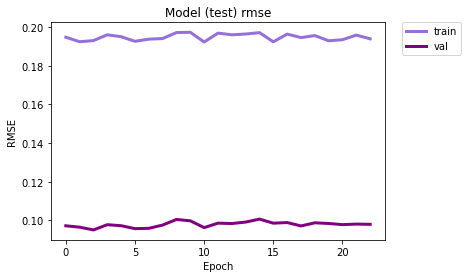

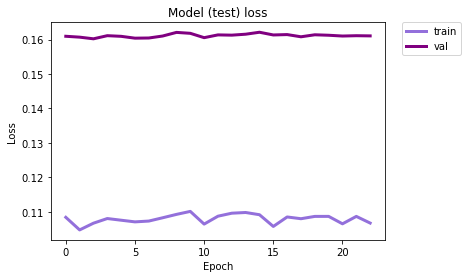

Epoch 1/300
9/9 [==============================] - 1s 104ms/step - loss: 0.1292 - mae: 0.0719 - rmse: 0.1246 - val_loss: 0.0647 - val_mae: 0.0525 - val_rmse: 0.0818
Epoch 2/300
9/9 [==============================] - 1s 107ms/step - loss: 0.1333 - mae: 0.0717 - rmse: 0.1262 - val_loss: 0.0633 - val_mae: 0.0498 - val_rmse: 0.0814
Epoch 3/300
9/9 [==============================] - 1s 120ms/step - loss: 0.1366 - mae: 0.0737 - rmse: 0.1301 - val_loss: 0.0626 - val_mae: 0.0477 - val_rmse: 0.0813
Epoch 4/300
9/9 [==============================] - 1s 121ms/step - loss: 0.1350 - mae: 0.0720 - rmse: 0.1275 - val_loss: 0.0623 - val_mae: 0.0469 - val_rmse: 0.0814
Epoch 5/300
9/9 [==============================] - 1s 115ms/step - loss: 0.1321 - mae: 0.0694 - rmse: 0.1252 - val_loss: 0.0626 - val_mae: 0.0480 - val_rmse: 0.0813
Epoch 6/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1321 - mae: 0.0694 - rmse: 0.1251 - val_loss: 0.0627 - val_mae: 0.0481 - val_rmse: 0.0813
Epoch 7/300

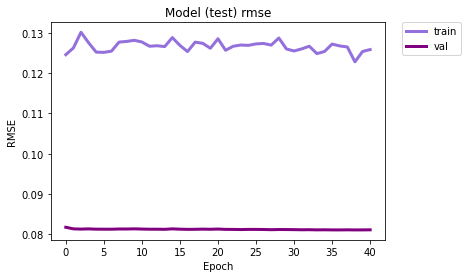

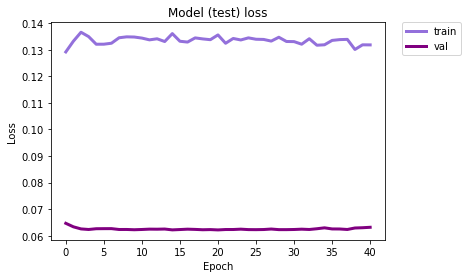

Epoch 1/300
11/11 [==============================] - 1s 96ms/step - loss: 0.1218 - mae: 0.0657 - rmse: 0.1176 - val_loss: 0.1225 - val_mae: 0.0728 - val_rmse: 0.1257
Epoch 2/300
11/11 [==============================] - 1s 91ms/step - loss: 0.1205 - mae: 0.0658 - rmse: 0.1162 - val_loss: 0.1222 - val_mae: 0.0728 - val_rmse: 0.1254
Epoch 3/300
11/11 [==============================] - 1s 82ms/step - loss: 0.1213 - mae: 0.0665 - rmse: 0.1169 - val_loss: 0.1220 - val_mae: 0.0729 - val_rmse: 0.1253
Epoch 4/300
11/11 [==============================] - 1s 96ms/step - loss: 0.1216 - mae: 0.0669 - rmse: 0.1173 - val_loss: 0.1222 - val_mae: 0.0728 - val_rmse: 0.1254
Epoch 5/300
11/11 [==============================] - 1s 91ms/step - loss: 0.1223 - mae: 0.0669 - rmse: 0.1178 - val_loss: 0.1220 - val_mae: 0.0728 - val_rmse: 0.1253
Epoch 6/300
11/11 [==============================] - 1s 84ms/step - loss: 0.1217 - mae: 0.0676 - rmse: 0.1171 - val_loss: 0.1226 - val_mae: 0.0728 - val_rmse: 0.1258
Epoc

Epoch 50/300
11/11 [==============================] - 1s 111ms/step - loss: 0.1199 - mae: 0.0672 - rmse: 0.1154 - val_loss: 0.1209 - val_mae: 0.0729 - val_rmse: 0.1241
Epoch 51/300
11/11 [==============================] - 1s 103ms/step - loss: 0.1208 - mae: 0.0672 - rmse: 0.1166 - val_loss: 0.1212 - val_mae: 0.0728 - val_rmse: 0.1245
Epoch 52/300
11/11 [==============================] - 1s 93ms/step - loss: 0.1201 - mae: 0.0658 - rmse: 0.1162 - val_loss: 0.1216 - val_mae: 0.0728 - val_rmse: 0.1249
Epoch 53/300
11/11 [==============================] - 1s 128ms/step - loss: 0.1198 - mae: 0.0663 - rmse: 0.1158 - val_loss: 0.1216 - val_mae: 0.0728 - val_rmse: 0.1248
Epoch 54/300
11/11 [==============================] - 1s 115ms/step - loss: 0.1194 - mae: 0.0662 - rmse: 0.1154 - val_loss: 0.1210 - val_mae: 0.0728 - val_rmse: 0.1243
Epoch 55/300
11/11 [==============================] - 1s 97ms/step - loss: 0.1187 - mae: 0.0663 - rmse: 0.1145 - val_loss: 0.1204 - val_mae: 0.0729 - val_rmse: 0

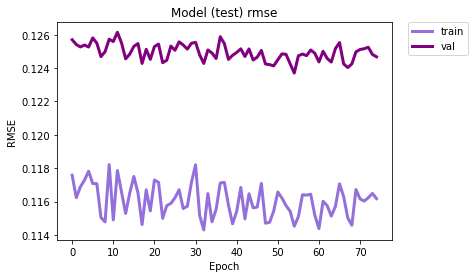

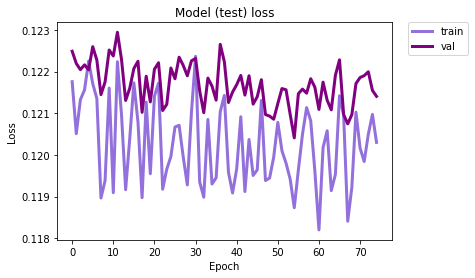

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.9658241
Transformed yhat 74.555046
yhat 0.966675
Transformed yhat 74.566124
yhat 0.96739197
Transformed yhat 74.57546
yhat 0.9679419
Transformed yhat 74.58262
yhat 0.9683596
Transformed yhat 74.58806
yhat 0.96861506
Transformed yhat 74.591385
yhat 0.9687592
Transformed yhat 74.59326
yhat 0.96882653
Transformed yhat 74.59413
yhat 0.9688449
Transformed yhat 74.594376
yhat 0.9688234
Transformed yhat 74.59409
yhat 0.96877927
Transformed yhat 74.59352
yhat 0.96872973
Transformed yhat 74.59287
Real data: [73.32692308 74.         74.         65.65384615 74.19607843 75.
 74.05769231 72.29411765 74.05769231 75.         74.         74.
 74.         74.         74.         74.         74.         74.
 74.         74.         74.         74.         73.65384615 75.        ]
Forecasting values: [74.6, 74.6, 74.6, 74.6, 74.6, 74.6, 74.6, 74.6, 74.6, 74.6, 74.6, 74.6]


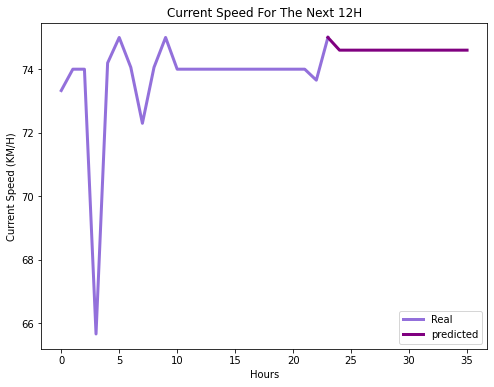

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.5',forecastSpeed[i],hour[i]
        writer.writerow(d)
